In [14]:
import os
import toml
from src import settings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from src.utils import fileio

CONFIG_PATH = os.path.join(settings.CONFIG_DIR, "main.toml")
with open(CONFIG_PATH, "r") as file:
    config = toml.load(file)
TIME_WINDOW=config["TIME_WINDOW"]
INPUT_PATH = os.path.join(settings.RESULTS_DIR, "local_measures_snapshots", f"{TIME_WINDOW}_sec_window/")
all_treatments = fileio.load_multiple_folders(INPUT_PATH)
all_treatments = {key: value for key, value in all_treatments.items() if key in config["TREATMENTS"]}

dataframes = []
for treatment_name, treatment_path in all_treatments.items():
    all_groups = fileio.load_multiple_folders(treatment_path)
    treatment_dataframes = []
    for group_name, group_path in all_groups.items():
        all_snapshots = fileio.load_files_from_folder(group_path)
        group_dataframes = []  # Create a list to store DataFrames for each group
        for snapshot_name, snapshot_path in all_snapshots.items():
            df = pd.read_csv(snapshot_path, index_col=0) 
            df['Snapshot'] = snapshot_name.replace('.csv', '')
            df['Group'] = group_name
            group_dataframes.append(df)  # Append the DataFrame to the list for the group
        group_combined_df = pd.concat(group_dataframes)  # Combine DataFrames for the group
        treatment_dataframes.append(group_combined_df)  # Append the combined DataFrame to the list

    combined_df = pd.concat(treatment_dataframes)
    combined_df = combined_df.set_index(['Group'], append=True)
    combined_df.index.names = ['Fly', 'Group']
    combined_df = combined_df.reorder_levels(['Fly', 'Group'])
    combined_df['Treatment'] = treatment_name
    combined_df = combined_df.set_index('Treatment', append=True)
    dataframes.append(combined_df)

combined_data = pd.concat(dataframes)

combined_data_reset = combined_data.reset_index()
combined_data_reset['Snapshot'] = combined_data_reset['Snapshot'].astype(int)


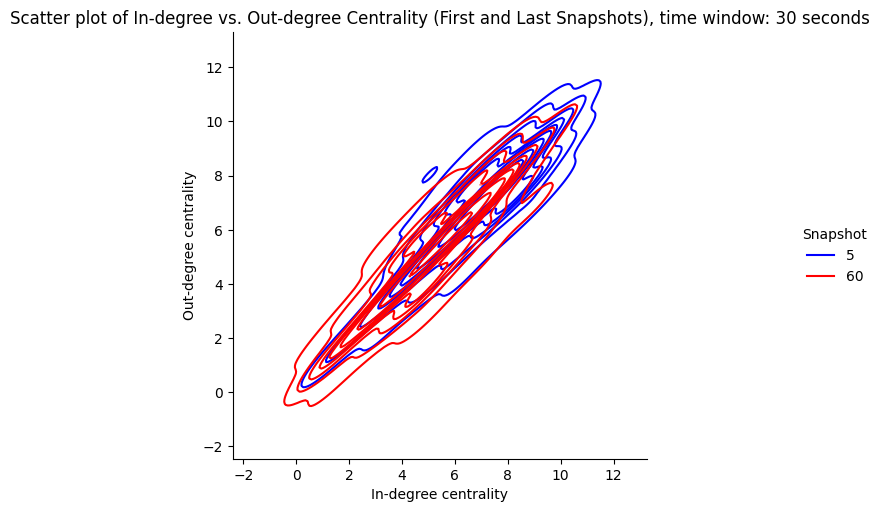

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have already loaded the data and reset the index as mentioned in your code

# Filter the DataFrame to get data from the first and last snapshots
first_snapshot_data = combined_data_reset[combined_data_reset["Snapshot"] == 5]
last_snapshot_data = combined_data_reset[combined_data_reset["Snapshot"] == combined_data_reset["Snapshot"].max()]

# Combine the first and last snapshot data
combined_first_last_data = pd.concat([first_snapshot_data, last_snapshot_data])

# Create a scatter plot using the first and last snapshot data
sns.displot(data=combined_first_last_data, x="In-degree", y="Out-degree", hue="Snapshot", palette=["blue", "red"], kind='kde')

# Set axis labels and title
plt.xlabel("In-degree centrality")
plt.ylabel("Out-degree centrality")
plt.title(f"Scatter plot of In-degree vs. Out-degree Centrality (First and Last Snapshots), time window: {TIME_WINDOW} seconds")

# Show the plot
plt.show()
